<a href="https://colab.research.google.com/github/FerdinanVieiraJr/Atividade1_UEMA_TopicosII/blob/main/ATIVIDADE_III_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Carregar os dados
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Verificar as dimensões
print(f"Shape de X_train: {X_train.shape}") # (50000, 32, 32, 3)
print(f"Shape de y_train: {y_train.shape}") # (50000, 1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Shape de X_train: (50000, 32, 32, 3)
Shape de y_train: (50000, 1)


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Pré-processar as entradas para o ResNet50
# Isso aplica a normalização específica que o ResNet50 espera
X_train_preprocessed = preprocess_input(X_train)
X_test_preprocessed = preprocess_input(X_test)

In [3]:
# Definir o tamanho da entrada (CIFAR-10)
INPUT_SHAPE = (32, 32, 3)

# 1. Carregar o Modelo Base (ResNet50)
base_model = ResNet50(input_shape=INPUT_SHAPE,
                            include_top=False,  # Não incluir a camada final (1000 classes)
                            weights='imagenet') # Carregar pesos pré-treinados do ImageNet [cite: 510]

# 2. Congelar o Modelo Base
# Não queremos retreinar o que ele já aprendeu [cite: 520]
base_model.trainable = False

# 3. Adicionar nossa Própria Cabeça Classificatória [cite: 521]
# Usamos a API Funcional do Keras
inputs = keras.Input(shape=INPUT_SHAPE)
# A base processa a entrada (em modo 'inference')
x = base_model(inputs, training=False)
# Adicionamos um Pooling para achatar os mapas de características
x = layers.GlobalAveragePooling2D()(x)
# Adicionamos uma camada Densa para nossa própria lógica
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x) # Dropout para regularização
# A camada de saída final (10 classes para o CIFAR-10)
outputs = layers.Dense(10, activation='softmax')(x)

# 4. Criar o Modelo Final
model_resnet50 = keras.Model(inputs, outputs)

model_resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Compilar o modelo [cite: 407]
model_resnet50.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy', # Usar "sparse" pois y_train são inteiros [cite: 406]
                         metrics=['accuracy'])

# Treinar o modelo
print("Iniciando o treinamento do ResNet50...")
history_resnet50 = model_resnet50.fit(X_train_preprocessed, y_train,
                                        epochs=10, # 10 épocas é um bom começo
                                        batch_size=64, # Como mostrado no slide [cite: 408]
                                        validation_data=(X_test_preprocessed, y_test))

Iniciando o treinamento do ResNet50...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5410 - loss: 1.7122 - val_accuracy: 0.6362 - val_loss: 1.0225
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6597 - loss: 0.9592 - val_accuracy: 0.6559 - val_loss: 0.9843
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6918 - loss: 0.8741 - val_accuracy: 0.6638 - val_loss: 0.9765
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7241 - loss: 0.7823 - val_accuracy: 0.6551 - val_loss: 1.0052
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7444 - loss: 0.7148 - val_accuracy: 0.6587 - val_loss: 1.0422
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7718 - loss: 0.6429 - val_accuracy: 0.6657 - val_loss: 1.0503
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7929 - loss: 0.5806 - val_accuracy: 0.6681 - val_loss: 1.0871
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - a

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6650 - loss: 1.2691
Acurácia final (ResNet50): 67.16%


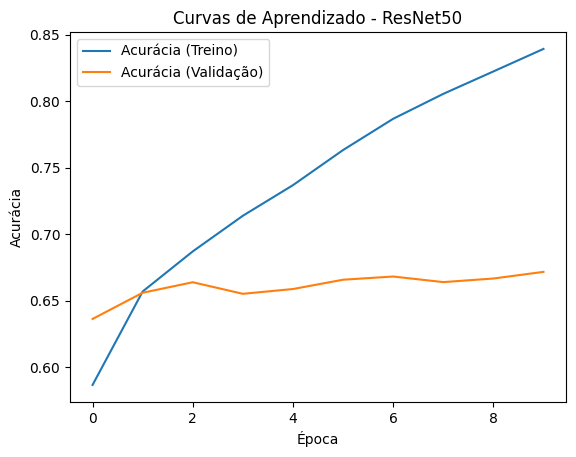

In [5]:
# Avaliar no conjunto de teste
loss, accuracy = model_resnet50.evaluate(X_test_preprocessed, y_test)
print(f"Acurácia final (ResNet50): {accuracy * 100:.2f}%")

# Plotar histórico de acurácia
plt.plot(history_resnet50.history['accuracy'], label='Acurácia (Treino)')
plt.plot(history_resnet50.history['val_accuracy'], label='Acurácia (Validação)')
plt.title('Curvas de Aprendizado - ResNet50')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [6]:
# Célula 1: Importações e Pré-processamento do MobileNetV2
from tensorflow.keras.applications import MobileNetV2
# Importamos a função de pré-processamento específica da MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
import matplotlib.pyplot as plt

# IMPORTANTE: Use o X_train/X_test original, não o pré-processado do ResNet
print("Pré-processando dados para MobileNetV2...")
# A função 'preprocess_input' da MobileNetV2 normaliza os pixels para o intervalo [-1, 1]
X_train_mobile = mobilenet_preprocess(X_train)
X_test_mobile = mobilenet_preprocess(X_test)

print("Dados prontos para o MobileNetV2!")

Pré-processando dados para MobileNetV2...
Dados prontos para o MobileNetV2!


In [7]:
# Célula 2: Construção do Modelo MobileNetV2

# 1. Carregar a Base (MobileNetV2)
base_model_mobile = MobileNetV2(input_shape=(32, 32, 3), # Mesmo shape do CIFAR
                                include_top=False,     # Sem a cabeça original
                                weights='imagenet')    # Com pesos do ImageNet

# 2. Congelar a Base
base_model_mobile.trainable = False

# 3. Adicionar nossa Cabeça Classificatória
# (Usaremos a mesma cabeça para uma comparação justa com o ResNet)
inputs_mobile = keras.Input(shape=(32, 32, 3))
x_mobile = base_model_mobile(inputs_mobile, training=False)
x_mobile = layers.GlobalAveragePooling2D()(x_mobile)
x_mobile = layers.Dense(1024, activation='relu')(x_mobile)
# Vamos manter o dropout em 0.3 por enquanto, para comparar com o primeiro run do ResNet
x_mobile = layers.Dropout(0.3)(x_mobile)
outputs_mobile = layers.Dense(10, activation='softmax')(x_mobile) # 10 classes

# 4. Criar o Modelo Final
model_mobile = keras.Model(inputs_mobile, outputs_mobile)

# Vamos ver a arquitetura
model_mobile.summary()

/tmp/ipython-input-684432405.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobile = MobileNetV2(input_shape=(32, 32, 3), # Mesmo shape do CIFAR


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,579,978 (13.66 MB)

 Trainable params: 1,321,994 (5.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Célula 3: Compilação e Treinamento

model_mobile.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

print("Iniciando o treinamento do MobileNetV2...")
history_mobile = model_mobile.fit(X_train_mobile, y_train,
                                    epochs=10,       # Mesmas 10 épocas
                                    batch_size=64,   # Mesmo batch size
                                    validation_data=(X_test_mobile, y_test))
print("Treinamento do MobileNetV2 concluído!")

Iniciando o treinamento do MobileNetV2...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.2527 - loss: 2.0433 - val_accuracy: 0.2988 - val_loss: 1.9225
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3086 - loss: 1.8974 - val_accuracy: 0.3061 - val_loss: 1.8982
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3183 - loss: 1.8560 - val_accuracy: 0.3101 - val_loss: 1.8928
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3290 - loss: 1.8284 - val_accuracy: 0.3105 - val_loss: 1.8921
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3342 - loss: 1.8100 - val_accuracy: 0.3138 - val_loss: 1.8889
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3465 - loss: 1.7805 - val_accuracy: 0.3056 - val_loss: 1.8911
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3532 - loss: 1.7570 - val_accuracy: 0.3155 - val_loss: 1.8943
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accur

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3145 - loss: 1.9111
Acurácia final (MobileNetV2): 31.10%


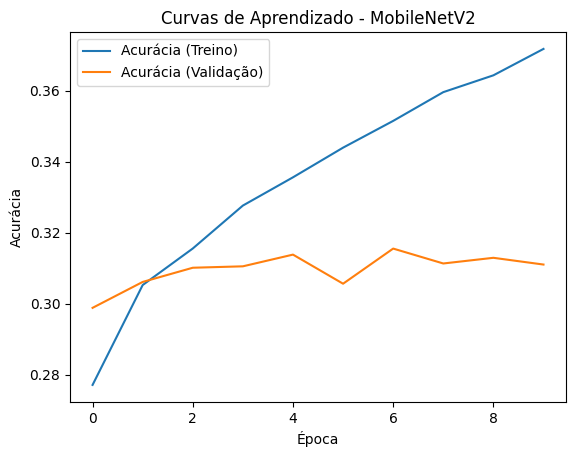

In [9]:
# Célula 4: Avaliação e Plotagem do MobileNetV2

# Avaliar no conjunto de teste
loss_m, accuracy_m = model_mobile.evaluate(X_test_mobile, y_test)
print(f"Acurácia final (MobileNetV2): {accuracy_m * 100:.2f}%")

# Plotar o histórico de acurácia
plt.plot(history_mobile.history['accuracy'], label='Acurácia (Treino)')
plt.plot(history_mobile.history['val_accuracy'], label='Acurácia (Validação)')
plt.title('Curvas de Aprendizado - MobileNetV2')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [10]:
# Célula 1: Importações e Pré-processamento do VGG16
from tensorflow.keras.applications import VGG16
# Importamos a função de pré-processamento específica da VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
import matplotlib.pyplot as plt

# IMPORTANTE: Use o X_train/X_test original
print("Pré-processando dados para VGG16...")
X_train_vgg = vgg_preprocess(X_train)
X_test_vgg = vgg_preprocess(X_test)

print("Dados prontos para o VGG16!")

Pré-processando dados para VGG16...
Dados prontos para o VGG16!


In [11]:
# Célula 2: Construção do Modelo VGG16

# 1. Carregar a Base (VGG16)
base_model_vgg = VGG16(input_shape=(32, 32, 3), # Tamanho exato do CIFAR
                         include_top=False,     # Sem a cabeça original
                         weights='imagenet')    # Com pesos do ImageNet

# 2. Congelar a Base
base_model_vgg.trainable = False

# 3. Adicionar nossa Cabeça Classificatória
# (Exatamente a mesma cabeça para uma comparação justa)
inputs_vgg = keras.Input(shape=(32, 32, 3))
x_vgg = base_model_vgg(inputs_vgg, training=False)
# A saída da base VGG16 em um input 32x32 será (1, 1, 512)
x_vgg = layers.GlobalAveragePooling2D()(x_vgg) # Achata para (512,)
x_vgg = layers.Dense(1024, activation='relu')(x_vgg)
x_vgg = layers.Dropout(0.3)(x_vgg) # Mesmo dropout para consistência
outputs_vgg = layers.Dense(10, activation='softmax')(x_vgg) # 10 classes

# 4. Criar o Modelo Final
model_vgg = keras.Model(inputs_vgg, outputs_vgg)

# VGG é uma rede grande, vamos ver o sumário
model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,250,250 (58.18 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Célula 3: Compilação e Treinamento

model_vgg.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

print("Iniciando o treinamento do VGG16...")
history_vgg = model_vgg.fit(X_train_vgg, y_train,
                              epochs=10,       # Mesmas 10 épocas
                              batch_size=64,   # Mesmo batch size
                              validation_data=(X_test_vgg, y_test))
print("Treinamento do VGG16 concluído!")

Iniciando o treinamento do VGG16...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5164 - loss: 3.9094 - val_accuracy: 0.6343 - val_loss: 1.0552
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6712 - loss: 0.9567 - val_accuracy: 0.6494 - val_loss: 1.0553
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7056 - loss: 0.8422 - val_accuracy: 0.6524 - val_loss: 1.0832
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7280 - loss: 0.7803 - val_accuracy: 0.6547 - val_loss: 1.0708
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7447 - loss: 0.7488 - val_accuracy: 0.6599 - val_loss: 1.1284
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7608 - loss: 0.7033 - val_accuracy: 0.6554 - val_loss: 1.1513
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7757 - loss: 0.6509 - val_accuracy: 0.6621 - val_loss: 1.1621
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step 

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6638 - loss: 1.3400
Acurácia final (VGG16): 66.10%


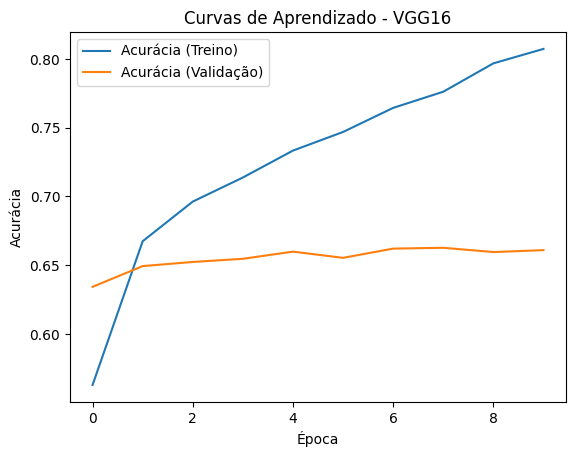

In [13]:
# Célula 4: Avaliação e Plotagem do VGG16

# Avaliar no conjunto de teste
loss_v, accuracy_v = model_vgg.evaluate(X_test_vgg, y_test)
print(f"Acurácia final (VGG16): {accuracy_v * 100:.2f}%")

# Plotar o histórico de acurácia
plt.plot(history_vgg.history['accuracy'], label='Acurácia (Treino)')
plt.plot(history_vgg.history['val_accuracy'], label='Acurácia (Validação)')
plt.title('Curvas de Aprendizado - VGG16')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [14]:
# Célula 1: Descongelando a base para o Fine-Tuning

# 'base_model' é o nosso ResNet50 que foi carregado antes
base_model.trainable = True

# Vamos definir um ponto para "descongelar".
# Congelaremos todas as camadas ANTES deste ponto.
fine_tune_at = 143 # Início do bloco 'conv5' do ResNet50

# Congele as camadas do início até 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print("Base do ResNet50 descongelada para Fine-Tuning.")
print(f"Total de layers na base: {len(base_model.layers)}")
print(f"Layers congeladas: {fine_tune_at}")
print(f"Layers treináveis: {len(base_model.layers) - fine_tune_at}")

Base do ResNet50 descongelada para Fine-Tuning.
Total de layers na base: 175
Layers congeladas: 143
Layers treináveis: 32


In [15]:
# Célula 2: Re-compilação com taxa de aprendizado baixa

from tensorflow.keras.optimizers import Adam

# 'model_resnet50' é o nosso modelo completo
model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-5), # <-- A REGRA DE OURO!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Vamos verificar a nova estrutura de treino
model_resnet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 17,084,426 (65.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [16]:
# Célula 3: Executando o Fine-Tuning

# 'history_resnet50' é a variável que guardou o primeiro treino
# 'X_train_preprocessed' e 'X_test_preprocessed' são os dados do ResNet

EPOCHS_INICIAIS = 10
EPOCHS_TOTAIS = 20 # Vamos treinar por mais 10

print("Iniciando o Fine-Tuning...")

history_finetune = model_resnet50.fit(
    X_train_preprocessed,
    y_train,
    epochs=EPOCHS_TOTAIS,
    initial_epoch=EPOCHS_INICIAIS, # Começa de onde paramos
    validation_data=(X_test_preprocessed, y_test)
)

print("Fine-Tuning concluído!")

Iniciando o Fine-Tuning...
Epoch 11/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 27ms/step - accuracy: 0.6157 - loss: 1.3617 - val_accuracy: 0.6013 - val_loss: 1.5610
Epoch 12/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.6989 - loss: 0.9266 - val_accuracy: 0.6212 - val_loss: 1.4020
Epoch 13/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7321 - loss: 0.7833 - val_accuracy: 0.6349 - val_loss: 1.3329
Epoch 14/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.7672 - loss: 0.6763 - val_accuracy: 0.6475 - val_loss: 1.2924
Epoch 15/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7906 - loss: 0.5891 - val_accuracy: 0.6545 - val_loss: 1.2722
Epoch 16/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8067 - loss: 0.5471 - val_accuracy: 0.6588 - val_loss: 1.2467
Epoch 17/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8244 - loss: 0.4908 - val_accuracy: 0.6676 - val_loss: 1.2373
Epoch 18/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6707 - loss: 1.2708
Acurácia final (pós Fine-Tuning): 67.45%


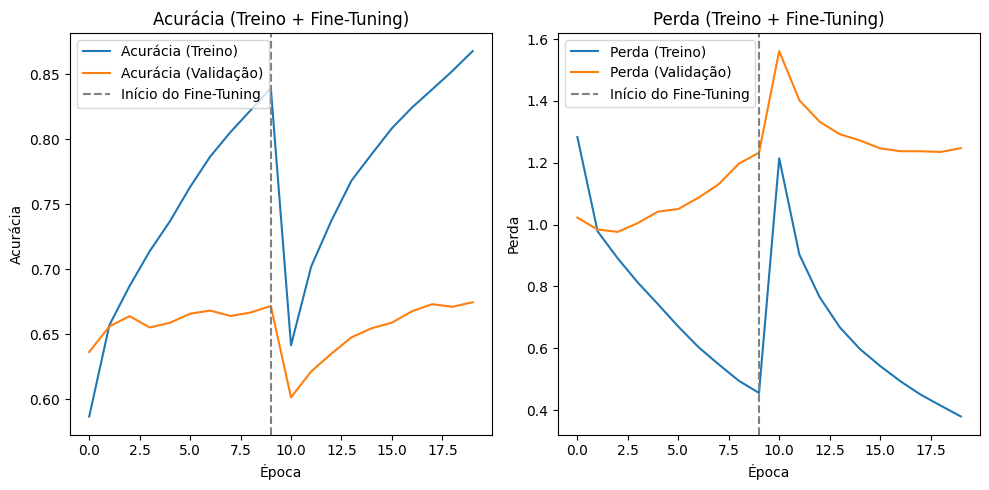

In [17]:
# Célula 4: Avaliação e Gráfico Combinado

# 1. Avaliar o resultado final
loss, accuracy = model_resnet50.evaluate(X_test_preprocessed, y_test)
print(f"Acurácia final (pós Fine-Tuning): {accuracy * 100:.2f}%")

# 2. Juntar os históricos
# 'history_resnet50' foi o primeiro treino (épocas 0-9)
# 'history_finetune' foi o segundo treino (épocas 10-19)

acc = history_resnet50.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history_resnet50.history['val_accuracy'] + history_finetune.history['val_accuracy']

loss_hist = history_resnet50.history['loss'] + history_finetune.history['loss']
val_loss_hist = history_resnet50.history['val_loss'] + history_finetune.history['val_loss']

# 3. Plotar o gráfico completo
plt.figure(figsize=(10, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia (Treino)')
plt.plot(val_acc, label='Acurácia (Validação)')
# Linha vertical para marcar o início do Fine-Tuning
plt.axvline(EPOCHS_INICIAIS - 1, linestyle='--', color='gray', label='Início do Fine-Tuning')
plt.title('Acurácia (Treino + Fine-Tuning)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(loss_hist, label='Perda (Treino)')
plt.plot(val_loss_hist, label='Perda (Validação)')
plt.axvline(EPOCHS_INICIAIS - 1, linestyle='--', color='gray', label='Início do Fine-Tuning')
plt.title('Perda (Treino + Fine-Tuning)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Célula 1: Continuando o Fine-Tuning (Épocas 20-29)

# 'history_finetune' foi o último histórico (épocas 10-19)
# 'model_resnet50' já está compilado

EPOCHS_ANTERIORES = 20
EPOCHS_TOTAIS_AGORA = 30 # Vamos treinar por mais 10

print("Continuando o Fine-Tuning...")

# Vamos rodar por mais 10 épocas, começando da 20
history_finetune_2 = model_resnet50.fit(
    X_train_preprocessed,
    y_train,
    epochs=EPOCHS_TOTAIS_AGORA,
    initial_epoch=EPOCHS_ANTERIORES, # Começa de onde paramos (época 20)
    validation_data=(X_test_preprocessed, y_test)
)

print("Treinamento adicional concluído!")

Continuando o Fine-Tuning...
Epoch 21/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8747 - loss: 0.3535 - val_accuracy: 0.6780 - val_loss: 1.2500
Epoch 22/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.8842 - loss: 0.3317 - val_accuracy: 0.6780 - val_loss: 1.2579
Epoch 23/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.8943 - loss: 0.3028 - val_accuracy: 0.6804 - val_loss: 1.2734
Epoch 24/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9022 - loss: 0.2809 - val_accuracy: 0.6832 - val_loss: 1.2777
Epoch 25/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9101 - loss: 0.2586 - val_accuracy: 0.6831 - val_loss: 1.2783
Epoch 26/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9168 - loss: 0.2455 - val_accuracy: 0.6872 - val_loss: 1.2860
Epoch 27/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9236 - loss: 0.2238 - val_accuracy: 0.6874 - val_loss: 1.3080
Epoch 28/30
1563/1563 ━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6831 - loss: 1.3798
Acurácia final (pós 30 épocas): 68.64%


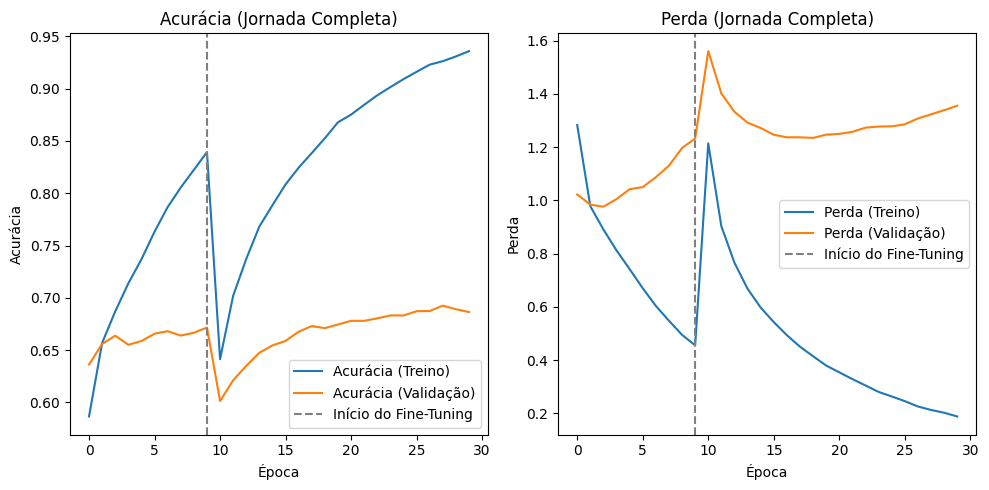

In [19]:
# Célula 2: Avaliação Final e Gráfico Completo (Épocas 0-29)

# 1. Avaliar o resultado finalíssimo
loss, accuracy = model_resnet50.evaluate(X_test_preprocessed, y_test)
print(f"Acurácia final (pós 30 épocas): {accuracy * 100:.2f}%")

# 2. Juntar TODOS os históricos
# 'history_resnet50' -> 0-9
# 'history_finetune' -> 10-19
# 'history_finetune_2' -> 20-29

acc = history_resnet50.history['accuracy'] + history_finetune.history['accuracy'] + history_finetune_2.history['accuracy']
val_acc = history_resnet50.history['val_accuracy'] + history_finetune.history['val_accuracy'] + history_finetune_2.history['val_accuracy']

loss_hist = history_resnet50.history['loss'] + history_finetune.history['loss'] + history_finetune_2.history['loss']
val_loss_hist = history_resnet50.history['val_loss'] + history_finetune.history['val_loss'] + history_finetune_2.history['val_loss']

# 3. Plotar o gráfico completo (0-29)
plt.figure(figsize=(10, 5))

# Gráfico de Acurácia
plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia (Treino)')
plt.plot(val_acc, label='Acurácia (Validação)')
# Linha vertical para marcar o início do Fine-Tuning
plt.axvline(9, linestyle='--', color='gray', label='Início do Fine-Tuning') # Marca na época 9
plt.title('Acurácia (Jornada Completa)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(loss_hist, label='Perda (Treino)')
plt.plot(val_loss_hist, label='Perda (Validação)')
plt.axvline(9, linestyle='--', color='gray', label='Início do Fine-Tuning') # Marca na época 9
plt.title('Perda (Jornada Completa)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()